In [2]:
##mount your drive 
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Install/Load Packages

*Internet access needs to be switched on for this to work!*

In [3]:
from IPython.utils import io
with io.capture_output() as captured:
    !pip install scispacy
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [4]:
import numpy as np 
import pandas as pd
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import scispacy
import spacy
import en_core_sci_lg
from scipy.spatial.distance import jensenshannon
import joblib
from IPython.display import HTML, display
from ipywidgets import interact, Layout, HBox, VBox, Box
import ipywidgets as widgets
from IPython.display import clear_output
from tqdm import tqdm
from os.path import isfile
import seaborn as sb
import matplotlib.pyplot as plt
plt.style.use("dark_background")
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
import regex as re
from gensim.models import Word2Vec
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import time
from contextlib import suppress
from sklearn.metrics.pairwise import cosine_similarity
from pandas import HDFStore, DataFrame, read_csv, concat
import tables
import warnings
#from rank_bm25 import BM25Okapi
import gensim
from scipy.spatial import distance
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from nltk.corpus import wordnet    
import csv
from datetime import datetime
from itertools import chain
from collections import defaultdict
import itertools
from itertools import chain, combinations
import random
from collections import Counter
import sys
import warnings
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
porter = PorterStemmer()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load and Prepare Data

In [5]:
filepath = '/content/drive/My Drive/dataset/'
df = pd.read_csv(filepath +'cord19_df2.csv')
model = Word2Vec.load(filepath +'covid_w2v_model_2')
all_texts = df.body_text

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [6]:
def sentences(recommended):
  recommended['abstract'] = recommended['abstract'].astype(str) 
  recommended['body_text'] = recommended['body_text'].astype(str) 
  recommended['title'] = recommended['title'].astype(str) 
  recommended['complete_text'] = recommended[['title','abstract', 'body_text']].agg('. '.join, axis=1)
  recommended['sentences'] = ''
  recommended['token_clean_sentences'] = ''
  recommended['vector_set'] = ''
  recommended['vector_set'] = ''
  recommended['prc_sents'] = ''
  sentences_dataset = []
  for i in range(0,len(recommended)):
      paper_sentences = []
      paper_sentences = recommended.complete_text.values[i].split('.')
      sentences_dataset = sentences_dataset + paper_sentences
      recommended.at[recommended.index[i], 'sentences'] = paper_sentences
  #clean sentences which contain lower than 7 words 
  #tokenization
  ind = -1
  for paper_sentences in recommended.sentences.values:
    tokenised_sents_set = []
    clean_sent = []
    ind = ind + 1
    print(ind)
    paper_id = recommended.index[ind]
    for sentences in paper_sentences:
      if bool(sentences):
          sentences = sentences +" "+str(paper_id)
          input_str = sentences
          tokens = word_tokenize(input_str)
          stop_words = set(stopwords.words('english'))
          new_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI','-PRON-']
          stop_words = stop_words.union(new_words)
          tokenised_sents = [i for i in tokens if not i in stop_words]
          tokenised_sents = [i for i in tokenised_sents if len(i)>2]
          tokenised_sents = [lemmatizer.lemmatize(w) for w in tokenised_sents]
          if len(tokenised_sents) > 7:
            tokenised_sents_set.append(tokenised_sents)
            clean_sent.append(sentences)
    recommended.at[recommended.index[ind], 'token_clean_sentences'] = tokenised_sents_set
    recommended.at[recommended.index[ind], 'prc_sents'] = clean_sent
  return(recommended , sentences_dataset)

In [7]:
# medium model
nlp = en_core_sci_lg.load(disable=["tagger", "parser", "ner"])
nlp.max_length = 2472506
def spacy_tokenizer(sentence):
    return [word.lemma_ for word in nlp(sentence) if not (word.like_num or word.is_stop or word.is_punct or word.is_space or len(word)==1)]
# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

We consider the text body, but the approach could also be applied to the abstracts only.

# Latend Dirichlet Allocation

For preprocessing we use [scispaCy](https://allenai.github.io/scispacy/), which is a Python package containing [spaCy](https://spacy.io) models for processing biomedical, scientific or clinical text.

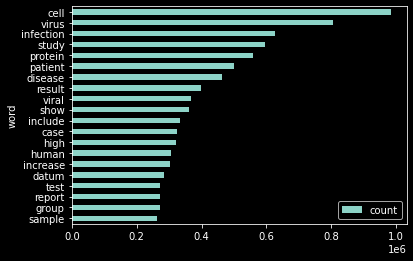

In [8]:


if not (isfile(filepath + 'vectorizer50.csv') & isfile(filepath + 'data_vectorized50.csv')):
    print('Files not there: generating')
    vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, max_features=800000)
    data_vectorized = vectorizer.fit_transform(tqdm(all_texts))
    joblib.dump(vectorizer, 'vectorizer50.csv')
    joblib.dump(data_vectorized, 'data_vectorized50.csv')
else:
    vectorizer = joblib.load(filepath + 'vectorizer50.csv')
    data_vectorized = joblib.load(filepath + 'data_vectorized50.csv')
if not (isfile(filepath + 'lda50.csv')):
  print('File not there: generating')
  lda = LatentDirichletAllocation(n_components=50, random_state=0)
  lda.fit(data_vectorized)
  joblib.dump(lda, 'lda50.csv')
else:
  lda = joblib.load(filepath + 'lda50.csv') 
# most frequent words
word_count = pd.DataFrame({'word': vectorizer.get_feature_names(), 'count': np.asarray(data_vectorized.sum(axis=0))[0]})

word_count.sort_values('count', ascending=False).set_index('word')[:20].sort_values('count', ascending=True).plot(kind='barh')

## Discovered Topics

In [9]:
def print_top_words(model, vectorizer, n_top_words):
    feature_names = vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        message = "\nTopic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
if not (isfile(filepath + 'doc_topic_dist50.csv')):
  print('File not there: generating')
  doc_topic_dist = pd.DataFrame(lda.transform(data_vectorized))
  doc_topic_dist.to_csv('doc_topic_dist50.csv', index=False)
else:
   doc_topic_dist = pd.read_csv(filepath + 'doc_topic_dist50.csv')  

is_covid19_article = df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')

def get_k_nearest_docs(doc_dist, k=5, lower=1950, upper=2020, only_covid19=False, get_dist=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    
    relevant_time = df.publish_year.between(lower, upper)
    
    if only_covid19:
        temp = doc_topic_dist[relevant_time & is_covid19_article]
        
    else:
        temp = doc_topic_dist[relevant_time]
         
    distances = temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
    
    if get_dist:
        k_distances = distances[distances != 0].nsmallest(n=k)
        return k_nearest, k_distances
    else:
        return k_nearest
def plot_article_dna(paper_id, width=20):
    t = df[df.paper_id == paper_id].title.values[0]
    doc_topic_dist[df.paper_id == paper_id].T.plot(kind='bar', legend=None, title=t, figsize=(width, 4))
    plt.xlabel('Topic')

def compare_dnas(paper_id, recommendation_id, width=20):
    t = df[df.paper_id == recommendation_id].title.values[0]
    temp = doc_topic_dist[df.paper_id == paper_id]
    ymax = temp.max(axis=1).values[0]*1.25
    temp = pd.concat([temp, doc_topic_dist[df.paper_id == recommendation_id]])
    temp.T.plot(kind='bar', title=t, figsize=(width, 4), ylim= [0, ymax])
    plt.xlabel('Topic')
    plt.legend(['Selection', 'Recommendation'])

# compare_dnas('90b5ecf991032f3918ad43b252e17d1171b4ea63', 'a137eb51461b4a4ed3980aa5b9cb2f2c1cf0292a')

def dna_tabs(paper_ids):
    k = len(paper_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = plot_article_dna(paper_ids[i])
            plt.show(ax)

def compare_tabs(paper_id, recommendation_ids):
    k = len(recommendation_ids)
    outs = [widgets.Output() for i in range(k)]

    tab = widgets.Tab(children = outs)
    tab_titles = ['Paper ' + str(i+1) for i in range(k)]
    for i, t in enumerate(tab_titles):
        tab.set_title(i, t)
    display(tab)

    for i, t in enumerate(tab_titles):
        with outs[i]:
            ax = compare_dnas(paper_id, recommendation_ids[i])
            plt.show(ax)

# Search related papers and find related sentences

As a similarity measure we use 1 - Jensen-Shannon distance.

## Sentence searching 

In [10]:
def find_sentences(recommended):
  recommended['abstract'] = recommended['abstract'].astype(str) 
  recommended['body_text'] = recommended['body_text'].astype(str) 
  recommended['title'] = recommended['title'].astype(str) 
  recommended['complete_text'] = recommended[['title','abstract', 'body_text']].agg('. '.join, axis=1)
  recommended['sentences'] = ''
  recommended['token_clean_sentences'] = ''
  recommended['vector_set'] = ''
  recommended['final_prc_sents'] = ''
  recommended['prc_sents'] = ''
  sentences_dataset = []
  for i in range(0,len(recommended)):
      paper_sentences = []
      paper_sentences = recommended.complete_text.values[i].split('.')
      sentences_dataset = sentences_dataset + paper_sentences
      recommended.at[recommended.index[i], 'sentences'] = paper_sentences
  #clean sentences which contain lower than 7 words 
  #tokenization
  ind = -1
  for paper_sentences in recommended.sentences.values:
    tokenised_sents_set = []
    clean_sent = []
    ind = ind + 1
    paper_id = recommended.index[ind]
    for sentences in paper_sentences:
      if bool(sentences):
          sentences = sentences +" "+str(paper_id)
          input_str = sentences
          tokens = word_tokenize(input_str)
          stop_words = set(stopwords.words('english'))
          new_words = ['doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI','-PRON-']
          stop_words = stop_words.union(new_words)
          tokenised_sents = [i for i in tokens if not i in stop_words]
          tokenised_sents = [i for i in tokenised_sents if len(i)>2]
          tokenised_sents = [lemmatizer.lemmatize(w) for w in tokenised_sents]
          if len(tokenised_sents) > 7:
            tokenised_sents_set.append(tokenised_sents)
            clean_sent.append(sentences)
    recommended.at[recommended.index[ind], 'token_clean_sentences'] = tokenised_sents_set
    recommended.at[recommended.index[ind], 'prc_sents'] = clean_sent
    #vectorization
    k = 0
    sentences_vector_set= []
    result_sentences = []
    for sentences_token in tokenised_sents_set:
      #print(k)
      words_vec = []
      for words in sentences_token:
          with suppress(Exception):
              words_vec.append(model[words])
      if bool(words_vec):  
        #print('**********************')   
        sents_vector = np.mean(words_vec, axis = 0)
        sentences_vector_set.append(sents_vector)
        result_sentences.append(clean_sent[k])
      #else:
        #print(ind,k)
      k = k+1      
    recommended.at[recommended.index[ind], 'vector_set'] = sentences_vector_set
    recommended.at[recommended.index[ind], 'final_prc_sents'] = result_sentences
  return(recommended,sentences_dataset)    

## Create a vector for query.

In [11]:
def query_result(data, u_query , top_result = 5):
  #user_queries = ["Seasonality of transmission"]
  user_queries = u_query 
  tokenised_queries = []
  for query in user_queries:
      cleaned_user_query = []
      input_str = query
      stop_words = set(stopwords.words('english'))
      tokens = word_tokenize(input_str)
      tokenised_query = [i for i in tokens if not i in stop_words]
      tokenised_query = [i for i in tokenised_query if len(i)>2]
      tokenised_query = [lemmatizer.lemmatize(w) for w in tokenised_query]
      cleaned_user_query.append(tokenised_query)
      tokenised_queries.append(cleaned_user_query)
  #vectorization
  queries_vector_set = []
  for i in range (len(tokenised_queries)):
      words_set = tokenised_queries[i][0]
      words_vec = []
      for words in words_set:
          with suppress(Exception):
              words_vec.append(model[words])
      query_vector = np.mean(words_vec, axis = 0)
      queries_vector_set.append(query_vector)
    # find similar
  mostsimilar_sentence_set = []
  vec1 = queries_vector_set[0].reshape(1, -1)
  sorted_results = {}
  result = {}
  top_k  = []
  i = 0
  for vector in data.vector_set.values:
    vec2 = vector.reshape(1, -1)
    dis = cosine_similarity(vec1, vec2)
    result[i] = dis
    i = i + 1
  sorted_results = {k: result[k] for k in sorted(result, key=result.get , reverse=True)}
  top_k = list(sorted_results.keys())[0:top_result]
  #print(top_k)
  mostsimilar_sentence = []
  for keys in top_k:
      #print(keys, "==" , data.final_prc_sents.values[keys])
      mostsimilar_sentence.append(data.final_prc_sents.values[keys])
  mostsimilar_sentence_set.append(mostsimilar_sentence)

  return(mostsimilar_sentence_set)

In [12]:
def related_papers():
    '''
    Creates a widget where you can select one of many papers about covid-19 and then displays related articles from the whole dataset.
    '''
    covid_papers = df[df.body_text.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')][['paper_id', 'title']] # are there more names?
    title_to_id = covid_papers.set_index('title')['paper_id'].to_dict()
    
    def main_function(bullet, k=5, year_range=[1950, 2020], only_covid19=False):
        recommendation(title_to_id[bullet], k, lower=year_range[0], upper=year_range[1], only_covid19=only_covid19)
    
    yearW = widgets.IntRangeSlider(min=1950, max=2020, value=[2010, 2020], description='Year Range', 
                                   continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=False,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='20%'))
    kWidget = widgets.IntSlider(value=10, description='k', max=50, min=1, layout=Layout(width='20%'))

    bulletW = widgets.Select(options=title_to_id.keys(), layout=Layout(width='90%', height='200px'), description='Title:')

    widget = widgets.interactive(main_function, bullet=bulletW, k=kWidget, year_range=yearW, only_covid19=covidW)

    controls = VBox([Box(children=[widget.children[:-1][1], widget.children[:-1][2], widget.children[:-1][3]], 
                         layout=Layout(justify_content='space-around')), widget.children[:-1][0]])
    output = widget.children[-1]
    display(VBox([controls, output]))

# Browse Tasks

We can now also map a task or bullet point into the topic space and find related articles that might help to solve the question at hand.

Note: Some of the bullet points are very short - results might not be reliable in this case.  

In [13]:
def relevant_articles(tasks, k=3, lower=1950, upper=2020, only_covid19=False ):
    top_paper_as_relerelevant = k*20
    top_sentences_number_for_primary_analyse = k*20
    sentences_number = top_sentences_number_for_primary_analyse
    if not sys.warnoptions:
        warnings.simplefilter("ignore")
    tasks = [tasks] if type(tasks) is str else tasks 
    
    tasks_vectorized = vectorizer.transform(tasks)
    tasks_topic_dist = pd.DataFrame(lda.transform(tasks_vectorized))
    Q_number = 1
    for index, bullet in enumerate(tasks):
        print ("***************************************** Question %s *********************************************************" %(Q_number))
        print("")
        print(bullet)
        print("")
        print ("***************************************** Related papers *****************************************************")
        recommended = get_k_nearest_docs(tasks_topic_dist.iloc[index], top_paper_as_relerelevant , lower, upper, only_covid19)
        recommended = df.iloc[recommended]
        df_result , all_sentences = find_sentences(recommended)
        result_sentences_set = []
        result_vector_set    = []
        for sentences_set in df_result.final_prc_sents.values:
          result_sentences_set =  result_sentences_set + sentences_set 
        for vectors in df_result.vector_set.values:
          result_vector_set =  result_vector_set + vectors
        data = {}
        data = {'final_prc_sents' : result_sentences_set , 'vector_set' : result_vector_set }
        df_allresults_sentences_vectors = pd.DataFrame(data)
        query = [bullet]
        #step2 -------------search in top 50 realted paper to chose top k paper 
        primary_sentences_result = query_result(df_allresults_sentences_vectors, query , sentences_number)
        result_paper_id = []
        for result_sent  in primary_sentences_result[0]:
          word_list = result_sent.split()
          result_paper_id.append(word_list[-1])
        top_k_result = Counter(result_paper_id).most_common(k)


        
        top_k_paper_id = {}
        for indx in range(len(top_k_result) ):
          key = list(list(top_k_result)[indx])[0]
          value = list(list(top_k_result)[indx])[1]
          top_k_paper_id.update({key:value})
        #print(top_k_paper_id)
        #{'29312': 11, '29961': 10, '29541': 9, '29558': 8, '29966': 7, '29659': 7}
        top_k_values = list(top_k_paper_id.values())
        
        keys_sentences_dict = {}
        for keys in top_k_paper_id.keys():
          top_sent_in_paper = []
          for sentences in primary_sentences_result[0]:
            word_list = sentences.split()
            if str(keys) in word_list[-1]:  
               top_sent_in_paper.append(sentences)
          keys_sentences_dict.update ({keys : top_sent_in_paper})
        #print(keys_sentences_dict)
        #{'29312': ['\nEstimates of incubation period and serial interval from other studies are shown in Table S4  29312',..]}
        #list(keys_sentences_dict.values())[0])



        top_k_index = list(top_k_paper_id.keys())
        df_list = []
        for indx in top_k_index:
          df_list.append(recommended.loc[[int(indx)]])
        frames = df_list
        result_paper_df = pd.concat(frames)
        
        
        
        ids = 0
        for l, n in result_paper_df[['url','title']].values:
          #h = '<br/>'.join(['<a href="' + l + '" target="_blank">'+ n + '</a>' for l, n in recommended[['url','title']].values])
          h = '<br/>'.join(['<a href="' + str(l) + '" target="_blank">'+ str(n) + '</a>'])
          display(HTML(h))
          print("")
          print("================= >>> Related sentences :")
          i = 0
          for most_similar_sentences in (list(keys_sentences_dict.values())[ids]):
              if i < 10 :
                print(most_similar_sentences)
                print("")
                i = i + 1
          ids = ids +1
        Q_number = Q_number + 1 

In [14]:
def relevant_articles_for_text():    
    textW = widgets.Textarea(
        value='',
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='200px')
    )

    yearW = widgets.IntRangeSlider(min=1950, max=2020, value=[2010, 2020], description='Year Range', 
                               continuous_update=False, layout=Layout(width='40%'))
    covidW = widgets.Checkbox(value=True,description='Only COVID-19-Papers',disabled=False, indent=False, layout=Layout(width='25%'))
    kWidget = widgets.IntSlider(value=6, description='k', max=50, min=1, layout=Layout(width='25%'))

    button = widgets.Button(description="Search")

    display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
        textW, button], layout=Layout(align_items='center')))

    def on_button_clicked(b):
        clear_output()
        display(VBox([HBox([kWidget, yearW, covidW], layout=Layout(width='90%', justify_content='space-around')),
            textW, button], layout=Layout(align_items='center')))        
        relevant_articles(textW.value, kWidget.value, yearW.value[0], yearW.value[1], covidW.value)

    button.on_click(on_button_clicked)

#Search box

In [15]:
pd.options.mode.chained_assignment = None 
warnings.filterwarnings("ignore", category=tables.NaturalNameWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

relevant_articles_for_text()